# Opdracht
## XML-dataset

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

xml_20000 = open('processen20000.xml', 'r').read()  # Read file
xml_10000 = open('processen10000.xml', 'r').read()
# root = ET.XML(xml_data)  # Parse XML

df_20000 = pd.read_xml(xml_20000)
df_10000 = pd.read_xml(xml_10000)

In [3]:
df_10000.head()

,pid,arrivaltime,servicetime
0,1,209,46
1,2,336,220
2,3,486,82
3,4,772,165
4,5,825,188


De tijden zijn niet in seconden, maar in aantal JIFFY’s. Een JIFFY is de tijd tussen twee “system timer”-interrupts. Er kan enkel gescheduled worden, beslissen welk proces aan de beurt is, bij een interrupt. Hier is de waarde van de JIFFY 10 ms.

## Processtrategiën
FCFS, SJF, SRT, RR, HRRN, en multilevel feedback mode.

Van het FCFS, SJF, SRT en HRRN algoritme maak je 1 versie. Het RR algoritme wordt geïmplementeerd met time slices q = 2, q = 4 en q = 8.
Voor het multilevel feedback algoritme maak je twee versies, telkens met 5 wachtrijen. Maak hier zelf een goeie keuze voor de time slices per wachtrij.
Motiveer de keuze in het verslag. Uiteraard mag je er meer implementeren dan deze. Schenk bij de implementatie van deze strategie¨en aandacht aan het ontwerp.
Indien de modellering goed verlopen is, zal je minder problemen hebben in deze fase.


## Evaluatie testresultaten

Voor het evalueren van de scheduler bepaal je aan de hand van een testrun een aantal grootheden:
- per proces: aankomsttijd, bedieningstijd , starttijd, eindtijd, omlooptijd, genormaliseerde omlooptijd en wachttijd
- globale parameters: gemiddelde omlooptijd, gemiddelde genormaliseerde omlooptijd en gemiddelde wachttijd

De resultaten breng je in twee grafieken:
- genormaliseerde omlooptijd in functie van bedieningstijd
- wachttijd in functie van bedieningstijd

De bedieningstijd verdeel je in percentielen. Voorbeeld voor 20000 processen: het eerste percentiel bestaat
uit de 200 kortste bedieningstijden.

In [4]:
# berekenen globale parameters:

def global_params(df, title):
    ''' functie voor de globale parameters bruikbaar voor elke strategie '''
    # gemiddelde omlooptijd:
    tat = df["TAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    normtat = df["normTAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    wait = df["waittime"].mean()

    params = (tat, normtat, wait)
    
    print("===================")
    print(title)
    print("===================")
    print ("gemiddelde omlooptijd bedraagt: "+ str(tat))
    print ("gemiddelde genormaliseerde omlooptijd bedraagt: "+ str(normtat))
    print ("gemiddelde wachttijd bedraagt: "+ str(wait))
    return params

# params_fcfs = global_params(df_fcfs, "FCFS")
# params_fcfs

In [5]:
import numpy as np

# omzetten naar percentielen voor grafieken ( we maken hier een functie die we kunnen herbruiken
def df_to_perc(df):
    ''' turns a dataframe with x rows into one with 100 rows containing averages of every group of  x/100 rows of the original dataframe '''
    df_sort = df.sort_values('servicetime', axis = 0)
    df_perc = df_sort.groupby(np.arange(len(df_sort))//(len(df_sort)/100)).mean()
    df_fin = df_perc.drop(['pid','arrivaltime', 'starttime', 'TAT', 'endtime'], axis = 1)                            
    return df_fin

In [6]:
import matplotlib.pyplot as plt

def evaluate(df, title):
    ''' functie die de hele evaluatie maakt en uitprint van een dataframe die de nodige waarden bevat voor een scheduling strategie '''
    params = global_params(df, title)
    df_plot = df_to_perc(df)
    plt.plot(df_plot['servicetime'], df_plot['normTAT'])
    plt.xlabel('bedieningstijd [ms]')
    plt.ylabel('genormaliseerde omlooptijd')
    plt.show()
    
    plt.plot(df_plot['servicetime']*10, df_plot['waittime']*10)
    plt.xlabel('bedieningstijd [ms]')
    plt.ylabel('wachttijd [ms]')
    plt.show()
    
# evaluate(df_fcfs, "FCFS")
    


### FCFS
First Come First Served.
Implementatie: simpel, steeds bij de arrival time de service time optellen en kijken of het volgende proces heeft gewacht of niet.

FCFS voor 10000 processen
gemiddelde omlooptijd bedraagt: 540.6591
gemiddelde genormaliseerde omlooptijd bedraagt: 26.936940030909312
gemiddelde wachttijd bedraagt: 441.0112


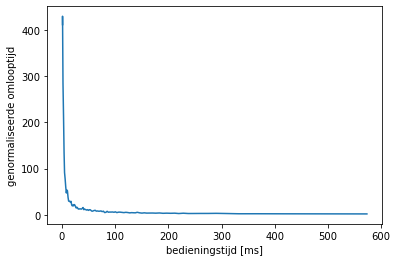

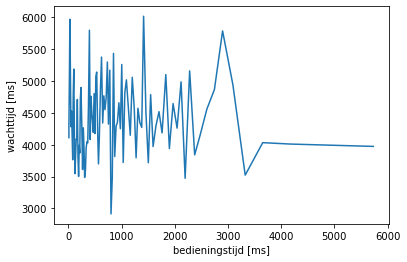

FCFS voor 20000 processen
gemiddelde omlooptijd bedraagt: 536.4218
gemiddelde genormaliseerde omlooptijd bedraagt: 22.967932932487884
gemiddelde wachttijd bedraagt: 435.63885


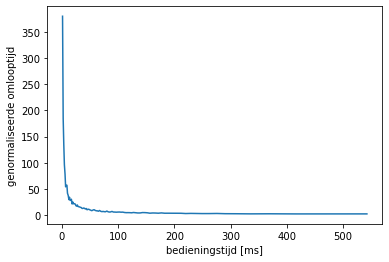

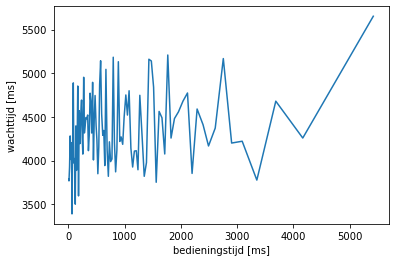

In [7]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
def FCFS(df):
    df_fcfs = df.copy()
    df_fcfs["starttime"] = df_fcfs["arrivaltime"]
    df_fcfs["waittime"] = 0
    df_fcfs["endtime"] = df_fcfs["arrivaltime"] + df_fcfs["servicetime"]

    for i in range(1, len(df_fcfs)):
        # als het proces toekomt alvorens het vorige proces klaar is (deze if loop is als het ware de scheduler):
        if df_fcfs.at[i-1, "endtime"] > df_fcfs.at[i, "arrivaltime"]: 
            # wachttijd berekenen
            df_fcfs.at[i, "waittime"] = df_fcfs.at[i-1, "endtime"] - df_fcfs.at[i, "arrivaltime"] 
            # starttijd bijstellen met wachttijd
            df_fcfs.at[i, "starttime"] = df_fcfs.at[i-1, "endtime"] 
        # eindtijd berekenen op basis van (aangepaste) starttijd en bedieningstijd
        df_fcfs.at[i, "endtime"] = df_fcfs.at[i, "starttime"] + df_fcfs.at[i, "servicetime"] 
    # Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
    df_fcfs["TAT"] = df_fcfs["servicetime"] + df_fcfs["waittime"]
    # idem voor de genormaliseerde TAT:
    df_fcfs["normTAT"] = df_fcfs["TAT"]/df_fcfs["servicetime"]
    
    return df_fcfs

evaluate(FCFS(df_10000), "FCFS voor 10000 processen")    
evaluate(FCFS(df_20000), "FCFS voor 20000 processen") 

### SJF
Shortest Job First. Implementatie: telkens er overgegaan wordt op een ander proces, eerst alle pocessen in wacht sorteren op service time, dan in volgorde uitvoeren.

FCFS voor 10000 processen
gemiddelde omlooptijd bedraagt: 540.6591
gemiddelde genormaliseerde omlooptijd bedraagt: 26.936940030909312
gemiddelde wachttijd bedraagt: 441.0112


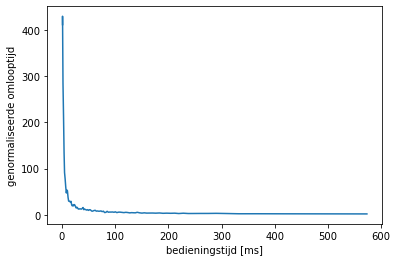

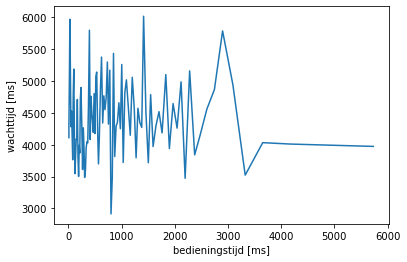

FCFS voor 20000 processen
gemiddelde omlooptijd bedraagt: 536.4218
gemiddelde genormaliseerde omlooptijd bedraagt: 22.967932932487884
gemiddelde wachttijd bedraagt: 435.63885


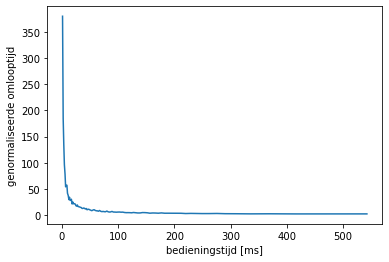

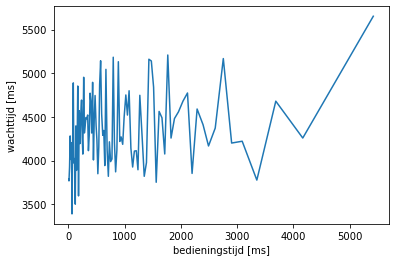

In [8]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
def SJF(df):
    df_sjf = df.copy()
    df_sjf["starttime"] = df_sjf["arrivaltime"]
    df_sjf["waittime"] = 0
    df_sjf["endtime"] = df_sjf["arrivaltime"] + df_sjf["servicetime"]
    
    df_sjf.sort_values('arrivaltime', axis = 0)

    for i in range(1, len(df_sjf)):
        # als het proces toekomt alvorens het vorige proces klaar is (deze if loop is als het ware de scheduler):
        if df_sjf.at[i-1, "endtime"] > df_sjf.at[i, "arrivaltime"]: 
            # wachttijd berekenen
            df_sjf.at[i, "waittime"] = df_sjf.at[i-1, "endtime"] - df_fcfs.at[i, "arrivaltime"] 
            # starttijd bijstellen met wachttijd
            df_sjf.at[i, "starttime"] = df_sjf.at[i-1, "endtime"] 
        # eindtijd berekenen op basis van (aangepaste) starttijd en bedieningstijd
        df_sjf.at[i, "endtime"] = df_sjf.at[i, "starttime"] + df_sjf.at[i, "servicetime"] 
    # Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
    df_sjf["TAT"] = df_sjf["servicetime"] + df_sjf["waittime"]
    # idem voor de genormaliseerde TAT:
    df_sjf["normTAT"] = df_sjf["TAT"]/df_sjf["servicetime"]
    
    return df_fcfs

evaluate(FCFS(df_10000), "FCFS voor 10000 processen")    
evaluate(FCFS(df_20000), "FCFS voor 20000 processen") 

In [13]:
df_sjf = df_10000.copy()
df_sjf["starttime"] = df_sjf["arrivaltime"]
df_sjf["waittime"] = 0
df_sjf["endtime"] = df_sjf["arrivaltime"] + df_sjf["servicetime"]

df_sjf.sort_values('arrivaltime', axis = 0)

for i in range(1, len(df_sjf)):
    # implementatie van de scheduler
    # Als er minstens 1 proces in wacht staat:
    if df_sjf.at[i-1, "endtime"] > df_sjf.at[i, "arrivaltime"]:
        # alle processen in wacht sorteren
        df_temp = df_sjf.loc[df_sjf['arrivaltime'] < df_sjf.at[i-1, 'endtime'], df_sjf[index] > i-1].sort_values('servicetime', axis = 0)

        df_sjf.at[i, "waittime"] = df_sjf.at[i-1, "endtime"] - df_fcfs.at[i, "arrivaltime"] 
        # starttijd bijstellen met wachttijd
        df_sjf.at[i, "starttime"] = df_sjf.at[i-1, "endtime"] 
    # eindtijd berekenen op basis van (aangepaste) starttijd en bedieningstijd
    df_sjf.at[i, "endtime"] = df_sjf.at[i, "starttime"] + df_sjf.at[i, "servicetime"] 
# Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
df_sjf["TAT"] = df_sjf["servicetime"] + df_sjf["waittime"]
# idem voor de genormaliseerde TAT:
df_sjf["normTAT"] = df_sjf["TAT"]/df_sjf["servicetime"]

NameError: name 'index' is not defined

In [17]:
df_sjf = df_10000.copy()
df_sjf["starttime"] = df_sjf["arrivaltime"]
df_sjf["waittime"] = 0
df_sjf["endtime"] = df_sjf["arrivaltime"] + df_sjf["servicetime"]

df_sjf.sort_values('arrivaltime', axis = 0)

for i in range(1, len(df_sjf)):
    # implementatie van de scheduler
    # Als er minstens 1 proces in wacht staat:
    if df_sjf.at[i-1, "endtime"] > df_sjf.at[i, "arrivaltime"]:
        # alle processen in wacht sorteren
        df_temp = df_sjf.loc[df_sjf['arrivaltime'] < df_sjf.at[i-1, 'endtime'], df_sjf.index > i-1].sort_values('servicetime', axis = 0)

IndexError: Boolean index has wrong length: 10000 instead of 6

In [16]:
df_sjf.head(-20)

,pid,arrivaltime,servicetime,starttime,waittime,endtime
0,1,209,46,209,0,255
1,2,336,220,336,0,556
2,3,486,82,486,0,568
3,4,772,165,772,0,937
4,5,825,188,825,0,1013
...,...,...,...,...,...,...
9975,9976,1239698,40,1239698,0,1239738
9976,9977,1239984,166,1239984,0,1240150
9977,9978,1240301,42,1240301,0,1240343
9978,9979,1240691,104,1240691,0,1240795


RR voor 10000 processen met q = 2
gemiddelde omlooptijd bedraagt: 99.6479
gemiddelde genormaliseerde omlooptijd bedraagt: 1.0
gemiddelde wachttijd bedraagt: 0.0


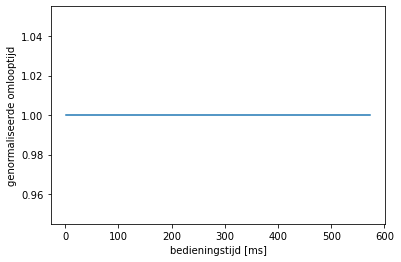

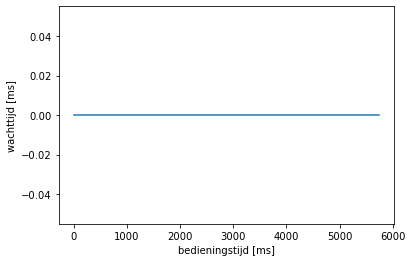

In [24]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
def RR(df,q):
    df_rr = df.copy()
    n = len(df_rr)
    
    df_rr["starttime"] = df_rr["arrivaltime"]
    df_rr["waitingtime"] = 0
    df_rr["TAT"] = 0
    df_rr["normTAT"] = 0
    
    df_rr["remainingTs"] = df_rr["servicetime"]
    t = 0
    
    tot_ts=0
    queue = []
    df_rr["timeremaining"] = df_rr["servicetime"]
    
    
    df_rr.sort_values('arrivaltime', axis = 0)
    
    for i in range(1, len(df_rr)):
        tot_ts+=df_rr.at[i,"servicetime"]
        
    for i in range (0,tot_ts):
        x = 0
        
        if df_rr.at[x,"servicetime"]==i:
            queue.append(df_rr.at[x,"pid"])
            x+=1
            
        if i//q==0 and len(queue)!=0:
            temp = queue.pop(0)
    
    df_rr["waittime"] = df_rr["starttime"] - df_rr["arrivaltime"]
    # Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
    df_rr["TAT"] = df_rr["servicetime"] + df_rr["waittime"]
    # idem voor de genormaliseerde TAT:
    df_rr["normTAT"] = df_rr["TAT"]/df_rr["servicetime"]
    
    df_rr["endtime"] = df_rr["starttime"] + df_rr["servicetime"]
          
    return df_rr

evaluate(RR(df_10000,2), "RR voor 10000 processen met q = 2")  

# evaluate(RR(df_20000,2), "RR voor 20000 processen met q = 2")
# evaluate(RR(df_10000,4), "RR voor 10000 processen met q = 4")    
# evaluate(RR(df_20000,4), "RR voor 20000 processen met q = 4")
# evaluate(RR(df_10000,8), "RR voor 10000 processen met q = 8")    
# evaluate(RR(df_20000,8), "RR voor 20000 processen met q = 8")


In [22]:
RR(df_10000,2)

KeyError: 'starttime'

In [13]:
FCFS(df_10000)

,pid,arrivaltime,servicetime,starttime,waittime,endtime,TAT,normTAT
0,1,209,46,209,0,255,46,1.000000
1,2,336,220,336,0,556,220,1.000000
2,3,486,82,556,70,638,152,1.853659
3,4,772,165,772,0,937,165,1.000000
4,5,825,188,937,112,1125,300,1.595745
...,...,...,...,...,...,...,...,...
9995,9996,1242620,132,1242941,321,1243073,453,3.431818
9996,9997,1242855,459,1243073,218,1243532,677,1.474946
9997,9998,1242918,47,1243532,614,1243579,661,14.063830
9998,9999,1243046,134,1243579,533,1243713,667,4.977612
